In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callback import *


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
path = untar_data(URLs.MNIST, dest='/media/puneet/Data/fastai')

In [4]:
path

PosixPath('/media/puneet/Data/fastai/mnist_png')

In [5]:
src = (ImageList.from_folder(path).split_none().label_from_folder()
      .transform(tfms=get_transforms(do_flip=False), size=32)
      .databunch(bs=4)
      .normalize(mnist_stats)
      )

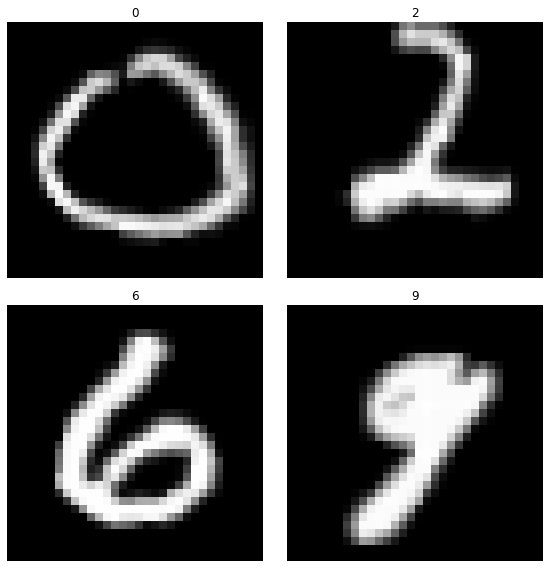

In [18]:
src.show_batch()

In [6]:
def fun(x):
    return x.mean(0).view(1)

def AvgFlatten():

    return Lambda(lambda x: fun(x))

def conv_layer1(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=False, bn:bool=True, 
                  leaky:bool=False, slope:float=0.1, transpose:bool=False):
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv2d
    activ = nn.LeakyReLU(inplace=True, negative_slope=slope) if leaky else nn.ReLU(inplace=True) 
    layers = [conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), activ]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

def discriminator(in_size, n_channels, n_features, n_extra_layers=0):
    layers = [conv_layer1(n_channels, n_features, 4, 2, 1, bn=False, leaky=True, slope=0.2)]
    cur_size, cur_ftrs = in_size//2, n_features
    layers.append(nn.Sequential(*[conv_layer1(cur_ftrs, cur_ftrs, 3, 1, leaky=True, slope=0.2) for _ in range(n_extra_layers)]))
    while cur_size > 4:
        layers.append(conv_layer1(cur_ftrs, cur_ftrs*2, 4, 2, 1, leaky=True, slope=0.2))
        cur_ftrs *= 2 ; cur_size //= 2
    layers += [conv2d(cur_ftrs, 1, 4, padding=0), AvgFlatten()]
    return nn.Sequential(*layers)

def generator(in_size, noise_sz, n_channels, n_features, n_extra_layers=0):
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < in_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [conv_layer1(noise_sz, cur_ftrs, 4, 1, transpose=True)]
    cur_size = 4
    while cur_size < in_size // 2:
        layers.append(conv_layer1(cur_ftrs, cur_ftrs//2, 4, 2, 1, transpose=True))
        cur_ftrs //= 2; cur_size *= 2
    layers += [conv_layer1(cur_ftrs, cur_ftrs, 3, 1, 1, transpose=True) for _ in range(n_extra_layers)]
    layers += [conv2d_trans(cur_ftrs, n_channels, 4, 2, 1, bias=False), nn.Tanh()]
    return nn.Sequential(*layers)

In [7]:
class BasicGAN(nn.Module):
    def __init__(self, in_size, noise_sz, n_channels, n_features, n_extra_layers=0):
        super().__init__()
        self.discriminator = discriminator(in_size, n_channels, n_features, n_extra_layers)
        self.generator = generator(in_size, noise_sz, n_channels, n_features, n_extra_layers)
    
    def forward(self, x, gen=False):
        return self.generator(x) if gen else self.discriminator(x)
    
def first_disc_iter(gen_iter):
    return 100 if (gen_iter < 25 or gen_iter%500 == 0) else 5

def standard_disc_iter(gen_iter):
    return 100 if gen_iter%500 == 0 else 5


noise_sz = 100
def create_noise(x, b, grad=True): 
    return x.new(b, noise_sz , 1, 1).normal_(0, 1).requires_grad_(grad)

In [8]:

class WasserteinLoss(nn.Module):
    def forward(self, real, fake): return real[0] - fake[0]

In [9]:
@dataclass
class GANTrainer(LearnerCallback):

    def __init__(self, learn):
        self.loss_fn = WasserteinLoss()
        self.bs = 8
        self.clip = 0.01
        self.n_disc_iter = first_disc_iter
        super().__init__(learn)
    
    def _set_trainable(self, gen=False):
        requires_grad(self.learn.model.generator, gen)
        requires_grad(self.learn.model.discriminator, not gen)
        if gen:
            self.opt_gen.lr, self.opt_gen.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_gen.wd, self.opt_gen.beta = self.learn.opt.wd, self.learn.opt.beta
    
    def on_train_begin(self, **kwargs):
        opt_fn = self.learn.opt_func
        lr, wd, true_wd, bn_wd = self.learn.opt.lr, self.learn.opt.wd, self.learn.opt.true_wd, self.learn.opt.bn_wd
        self.opt_gen = OptimWrapper.create(opt_fn, lr, 
                                      [nn.Sequential(*flatten_model(self.learn.model.generator))], 
                                      wd=wd, true_wd=true_wd, bn_wd=bn_wd)
        self.opt_disc = OptimWrapper.create(opt_fn, lr, 
                                      [nn.Sequential(*flatten_model(self.learn.model.discriminator))],
                                      wd=wd, true_wd=true_wd, bn_wd=bn_wd)
        self.learn.opt.opt = self.opt_disc.opt
        self.disc_iters, self.gen_iters = 0, 0
        self._set_trainable()
        self.dlosses,self.glosses = [],[]
    
    def on_batch_begin(self, **kwargs):
        for p in self.learn.model.discriminator.parameters(): 
            p.data.clamp_(-self.clip, self.clip)
        
    def on_backward_begin(self, last_output, last_input, **kwargs):
        
        fake = self.learn.model(create_noise(last_input, last_input.size(0), False), gen=True)
        fake.requires_grad_(True)
        loss = self.loss_fn(last_output, self.learn.model(fake))
        self.dlosses.append(loss.detach().cpu())
        return {'last_loss': -1*loss}
    
    def on_batch_end(self, last_input, **kwargs):
        self.disc_iters += 1
        if self.disc_iters == self.n_disc_iter(self.gen_iters):
            self.disc_iters = 0
            self._set_trainable(True)
            loss = self.learn.model(self.learn.model(create_noise(last_input,self.bs), gen=True)).mean(0).view(1)
            self.glosses.append(loss.detach().cpu())
            self.learn.model.generator.zero_grad()
            loss.backward()
            self.opt_gen.step()
            self.gen_iters += 1
            self._set_trainable()
            return {'last_loss': -1*loss}


In [10]:
class NoopLoss(nn.Module):

    def forward(self, output, target): 
        return output[0]
    

In [11]:
wgan = BasicGAN(32, 100, 3, 8, 1)
learn = Learner(src, wgan, loss_func=NoopLoss() , opt_func = optim.RMSprop, wd=0.1)
learn.callback_fns.append(ActivationStats)
cb = GANTrainer(learn)
learn.callbacks.append(cb)


In [12]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.031850,#na#,02:53


In [13]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,time
0,0.033312,#na#,02:49
1,0.029847,#na#,02:55
2,0.031282,#na#,02:43
3,0.034002,#na#,02:36
4,0.032456,#na#,02:37
5,0.029038,#na#,02:37
6,0.030299,#na#,02:36
7,0.019722,#na#,02:38
8,0.030030,#na#,02:37
9,0.031621,#na#,02:37


In [14]:
learn.save("model.h5")

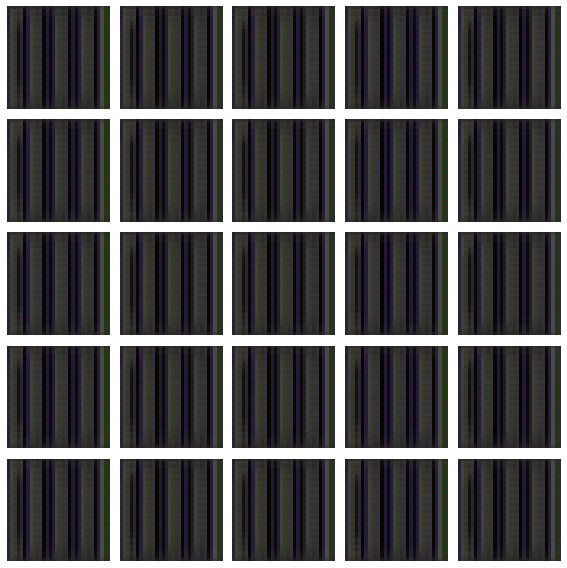

In [15]:
x,y = next(iter(learn.data.train_dl))

tst = learn.model(create_noise(x,64,False), gen=True)
imgs = src.denorm(tst.cpu()).numpy().clip(0,1)
fig,axs = plt.subplots(5,5,figsize=(8,8))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i].transpose(1,2,0))
    ax.axis('off')
plt.tight_layout()